# Introduction

I'll focus on developing a regression model to determine the interest rate int_rate from the available data. I outline in this notebook a three stage approach based on feature identification and selection, model selection and hyperparameter tuning

First some standard imports

In [1]:
#pandas, numpy and math for managing and manipulating our data
import pandas as pd
import numpy as np
import math

#matplotlib for data visualisation
import matplotlib
import matplotlib.pyplot as plt

First I load the dataset and then drop any duplicates there might be. The customer ID is set to be the index or unique identifier of the dataset

In [2]:
dataframe = pd.read_csv('DataScienceAssignment/DataScienceAssignment.csv')
dataframe.drop_duplicates(inplace=True)
dataframe.set_index('id',inplace=True)

Get some info on the dataframe

In [3]:
print('The total number of nan entries is %i'%(dataframe.isna().sum().sum()))
print('The columns with the most missing entries')
print(dataframe.isna().sum().sort_values()[::-1][0:10])

The total number of nan entries is 1042255
The columns with the most missing entries
desc                              69655
mths_since_last_record            62312
mths_since_recent_bc_dlq          56669
mths_since_last_major_derog       54833
mths_since_recent_revol_delinq    49199
il_util                           44224
mths_since_rcnt_il                40401
all_util                          39454
open_act_il                       39450
open_il_12m                       39450
dtype: int64


I split our dataset into features for predicting, and the true value of the interest rate (grade is dropped for now, could be done similarly)

In [4]:
X = dataframe.drop(labels=['int_rate','grade'],axis=1)
y = dataframe['int_rate']

# Define an array to keep track of any columns which should be dropped
columns_to_drop = []

# Feature Importance
Here I can run a mutual info regression algorithm on the numerical values to get an idea of the feature importance.

In [5]:
from sklearn.feature_selection import mutual_info_regression
X_num = X.select_dtypes(include=np.number).fillna(0)
X_cat = X.select_dtypes(['object']).fillna('None')
print('There are %i numerical features and %i categorical categories'%(X_num.shape[1], X_cat.shape[1]))

num_feature_importances=mutual_info_regression(X_num,y)

There are 88 numerical features and 23 categorical categories


Plot the feature importance for all, then the highest and lowest

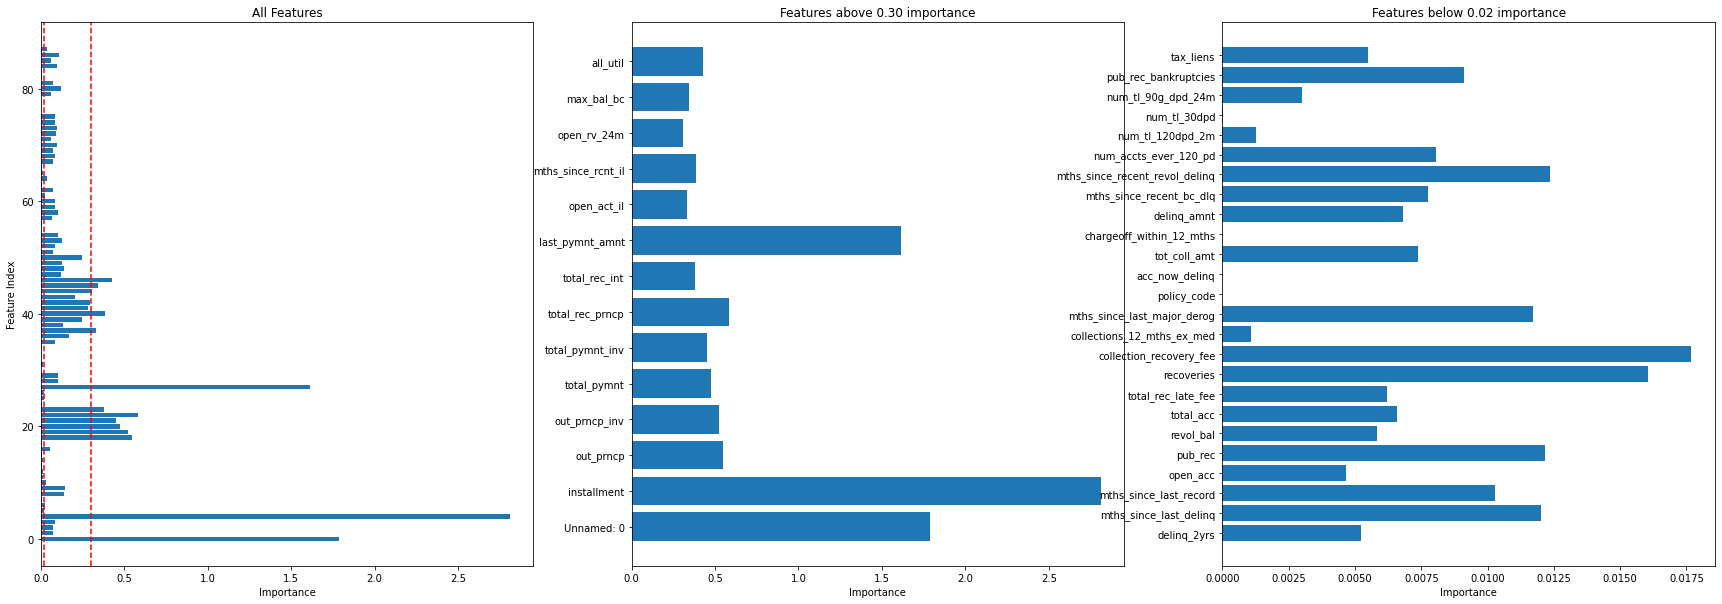

In [6]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (30,10))

#define some lo and hi thresholds
lo_threshold, hi_threshold = 0.02, 0.3

#make three dataframes, all, hi and lo based on importance thresholds
feature_importance_df = pd.DataFrame.from_dict({'feature' : X_num.columns.values, 'importance' : num_feature_importances})
feature_importance_df_hi = feature_importance_df[feature_importance_df['importance'] > hi_threshold]
feature_importance_df_lo = feature_importance_df[feature_importance_df['importance'] < lo_threshold]

# draw bar plots
ax1.barh(range(len(feature_importance_df))   , feature_importance_df['importance'])
ax2.barh(range(len(feature_importance_df_hi)), feature_importance_df_hi['importance'], tick_label = feature_importance_df_hi['feature'])
ax3.barh(range(len(feature_importance_df_lo)), feature_importance_df_lo['importance'], tick_label = feature_importance_df_lo['feature'])

#some lines for indication of the thresholds
ax1.axvline(x=lo_threshold, color = 'red', linestyle='--')
ax1.axvline(x=hi_threshold, color = 'red', linestyle='--')

# labels
ax1.set_ylabel('Feature Index')
ax1.set_xlabel('Importance')
ax2.set_xlabel('Importance')
ax3.set_xlabel('Importance')

#titles
ax1.set_title('All Features')
ax2.set_title('Features above %.2f importance'%hi_threshold)
ax3.set_title('Features below %.2f importance'%lo_threshold)

#and show
plt.show()

Let's illustrate these correlations visually, first by just plotting a histogram of the interest rate to show the range, and then plotting two features of high important (installment and last_pymnt_amnt) and one of low importance (collection_recovery_fee).

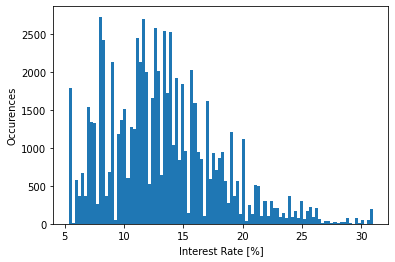

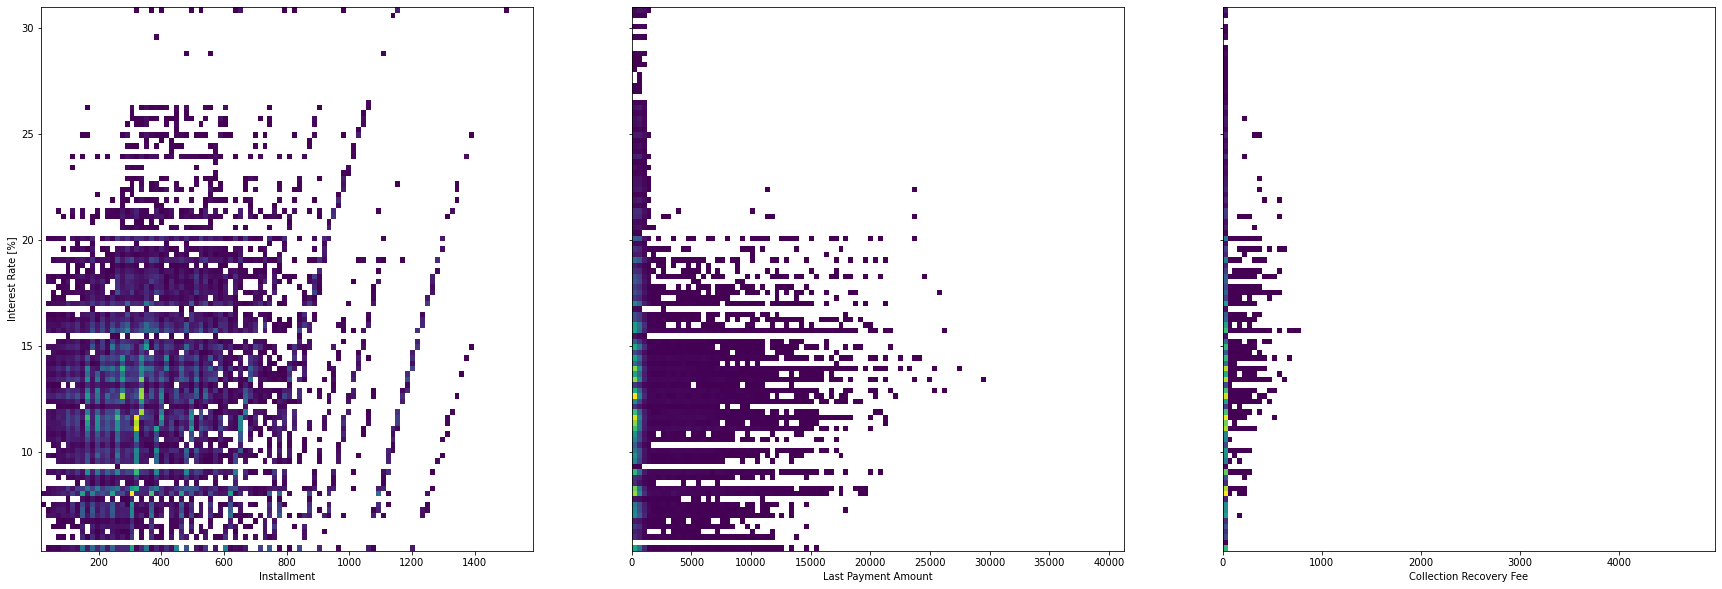

In [7]:
fig0, ax0 = plt.subplots()
ax0.hist(y, bins = 100)
ax0.set_ylabel('Occurences')
ax0.set_xlabel('Interest Rate [%]')
plt.show()

fig,(ax1,ax2,ax3) = plt.subplots(1,3, sharey=True, figsize = (30,10))
ax1.hist2d(X['installment'], y, bins = 100, density = False, cmin = 5)
ax2.hist2d(X['last_pymnt_amnt'],y, bins = 100, cmin = 5)
ax3.hist2d(X['collection_recovery_fee'],y, bins = 100, cmin = 5)
ax1.set_ylabel('Interest Rate [%]')
ax1.set_xlabel('Installment')
ax2.set_xlabel('Last Payment Amount')
ax3.set_xlabel('Collection Recovery Fee')

plt.show()


Although we see patterns, there isn't clear relationships we can benefit from, which indicates a simple model won't perform so well. Let's mark those numerical columns with low feature importance for removal. Note than Unnamed: 0 has a high importance, but probably for some other reason related to the data order, so including it will probably result in a large variance when we move to the test sample. Let's remove it.

In [8]:
columns_to_drop += feature_importance_df_lo['feature'].values.tolist()
columns_to_drop += [ 'Unnamed: 0']

# Sci-kit Learn Pipelines for Processing, Training and Predicting
Now that I have loaded our dataframe and identified the features, 'll make heavy use of pipelines in Scikit Learn to transform the data from its original form, perform the training, and predict the final results of any dataset. There are a number of advantages to this
1. Reproducibility
2. Ease of deployment
3. Ensure no data leakage

In [9]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor


First, a couple of custom functions for formatting the date and also reducing the number of unique categories of employee title

In [10]:
class DateFormatter(TransformerMixin):

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xdate = X.apply(pd.to_datetime).apply(pd.to_numeric)
        return Xdate

class EmpTitleImputer(TransformerMixin):
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        counts = X[X.columns[0]].value_counts().to_frame()
        common = counts[counts[X.columns[0]] > 50].index.to_list()
        X[X.columns[0]] = np.where(X[X.columns[0]].isin(common)<50, 'None', X[X.columns[0]])
        return X

The first step is to set up a preprocessing pipeline. There are a number of steps involved
* Convert all date fields to a date time format
* Numeric features corresponding to "months since" are converted to a large value (as no information here indicates inf. and not 0)
* Other numeric features are filled with the mean if not available
* Categorical features with a relation (e.g. sub grade) are converted to Ordinals to maintain information about the hierarchy
* The emp_title field is adjusted so that only entries used over 50 times are considered a category, others are all grouped together (Note that there are 3300 unique emp titles in 75000 entries, so this greatly reduces the number of features). This is performed by the EmpTitleImputer custom function above
* All other non-numerical categories are One Hot Encodeed
* Some columns are dropped which shouldn't make their way into the final training as they are either all the same or don't provide useful information


In [11]:
# features which we don't want to use in the training
columns_to_drop += ['desc','title']

# any date features, which will be onverted to ordinals so they can be interpreted as numbers
date_features  = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']

#get all numeric features
numeric_features = make_column_selector(dtype_include =np.number)(X)
#we get the ones with months (needs special treatment) and then all others (which are not in our drop selection)
numeric_mths_features = [ f for f in numeric_features if ('mths_since_' in f and f not in columns_to_drop)]
numeric_rem_features  = [ f for f in numeric_features if (f not in numeric_mths_features and f not in columns_to_drop) ]

#our transformer for the date features
date_transformer = Pipeline(steps=[
    ('formatter', DateFormatter()),
    ('imputer', SimpleImputer(strategy='median', missing_values = np.nan)),
    ('scaler', StandardScaler())
    ]
)

#our generic numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', missing_values = np.nan)),
    ('scaler', StandardScaler())])

#our transformer for the months column
numeric_mths_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', missing_values = np.nan, fill_value = 100)),
    ('scaler', StandardScaler())])

#our ordinals, which are related to each other
ordinal_features = ['term','emp_length','sub_grade','debt_settlement_flag','hardship_flag','pymnt_plan']
ordinal_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='constant', missing_values = np.nan, fill_value = 'None')),
    ('encoder', OrdinalEncoder() ),
    ('scaler', StandardScaler())
])

#a special transformer for employee title to reduce the number of sparse features it creates
emp_title_feature = ['emp_title']
emp_title_transformer = Pipeline( steps = [
    ('imputer1', EmpTitleImputer()),
    ('imputer2', SimpleImputer(strategy='constant', missing_values = np.nan, fill_value = 'None')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# our general hot key encoder for categorical features
categorical_features = [ f for f in make_column_selector(dtype_include='object')(X) if (f not in ordinal_features and f not in columns_to_drop and f not in emp_title_feature) ]
categorical_transformer = Pipeline( steps = [
    ('imputer', SimpleImputer(strategy='constant', missing_values = np.nan, fill_value = 'None')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


Two processors are set up, a full one, and a simple one to evaluate the effects of the processing

In [12]:
# Full processor including date conversion, months to high values, ordinal encoding, and truncating the employee title categories
preprocessor = ColumnTransformer(
    transformers=[
        ('date', date_transformer, date_features),
        ('num', numeric_transformer, numeric_rem_features),
        ('num_mths', numeric_transformer, numeric_mths_features),
        ('emp_title', emp_title_transformer, emp_title_feature),
        ('ordinal', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features)]
        )

# Simpe processor converting nan to mean for numeric and hot key encoding all categorical
simple_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features + ordinal_features + emp_title_feature)]
        )



Do a train test split of 0.2 (could also do cross-validation here but would take a bit longer for the differnet models, I'll do this for hyperparameter tuning)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

Just to check out the size of the data after our column transformers, and perform a quick unit test here to make sure that we're not removing any columns we shouldn't be in the processing stage (note this has to be done after the fit transform)

In [14]:
output_frame = preprocessor.fit_transform(X_train)
output_simple_frame = simple_preprocessor.fit_transform(X_train)
print("The preprocessing step has reduced the feature size from %i to %i"%(output_simple_frame.shape[1], output_frame.shape[1]))

The preprocessing step has reduced the feature size from 29877 to 2044


In [15]:

transformer_dropped = [X_train.columns.to_list()[i] for i in preprocessor.transformers_[-1][-1]]
transformer_dropped.sort()
columns_to_drop.sort()
if transformer_dropped != columns_to_drop:
    print('Columns dropped by transformer but not in drop list', [b for b in transformer_dropped if b not in columns_to_drop])
    print('Columns in drop list but not dropped by transformer', [b for b in columns_to_drop if b not in transformer_dropped])
    raise RuntimeWarning('The requested variables to drop and the transformer dropped variables are not the same. Check for consistency')


# Linear Regression
First model to try is linear regression. For a test, we'll do this with the naive simple preprocessing first, then with the full preprocessing to seee the difference. The model here is based on the $R^2$ score and the mean squared error score is also included as it's most relevant for our test sample

In [16]:

# Append linear regression to the simple preprocessing pipeline.
clf_linear_simple = Pipeline(steps=[('preprocessor', simple_preprocessor),
                      ('regression', LinearRegression())])


clf_linear_simple.fit(X_train, y_train)
print("model score: %.3f" % clf_linear_simple.score(X_test, y_test))
print("root mean squared error (test)  : %.3f" % mean_squared_error( y_test, clf_linear_simple.predict(X_test)))
print("root mean squared error (train) : %.3f" % mean_squared_error( y_train, clf_linear_simple.predict(X_train)))

model score: 0.967
root mean squared error (test)  : 0.724
root mean squared error (train) : 0.211


In [17]:

# Append linear regression to the full preprocessing pipeline.
clf_linear = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', LinearRegression())])


clf_linear.fit(X_train, y_train)
print("model score: %.3f" % clf_linear.score(X_test, y_test))
print("root mean squared error (test)  : %.3f" % mean_squared_error( y_test, clf_linear.predict(X_test)))
print("root mean squared error (train) : %.3f" % mean_squared_error( y_train, clf_linear.predict(X_train)))

model score: 0.975
root mean squared error (test)  : 0.553
root mean squared error (train) : 0.493


Clearly the full preprocessing performs better here, and also trains much quicker because it has significantly less features to deal with. However, I can still likely do better with different models. I try three specific models, Lasso Regression, KNN Regression, and Gradient Boosted Decision Tree Regression.

# Lasso Regression

In [18]:
# Append Lasso regression to the preprocessing pipeline.
clf_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', Lasso())])

clf_lasso.fit(X_train, y_train)
print("model score: %.3f" % clf_lasso.score(X_test, y_test))
print("root mean squared error (test)  : %.3f" % math.sqrt(mean_squared_error( y_test, clf_lasso.predict(X_test))))
print("root mean squared error (train) : %.3f" % math.sqrt(mean_squared_error( y_train, clf_lasso.predict(X_train))))

model score: 0.911
root mean squared error (test)  : 1.394
root mean squared error (train) : 1.403


# KNN Regression

In [19]:
# Append KNN regression to the preprocessing pipeline.
clf_knn = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', KNeighborsRegressor())])

clf_knn.fit(X_train, y_train)
print("model score: %.3f" % clf_knn.score(X_test, y_test))
knn_test_predictions = clf_knn.predict(X_test)
knn_train_predictions = clf_knn.predict(X_train)
print("root mean squared error (test)  : %.3f" % math.sqrt(mean_squared_error( y_test, knn_test_predictions)))
print("root mean squared error (train) : %.3f" % math.sqrt(mean_squared_error( y_train, knn_train_predictions)))

model score: 0.649
root mean squared error (test)  : 2.772
root mean squared error (train) : 2.247


# Gradient Boosting Regression

In [20]:

# Append gradient boosting regression to the preprocessing pipeline.
clf_gradboost = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', GradientBoostingRegressor())])

clf_gradboost.fit(X_train, y_train)
print("model score: %.3f" % clf_gradboost.score(X_test, y_test))
print("root mean squared error (test)  : %.3f" % math.sqrt(mean_squared_error( y_test, clf_gradboost.predict(X_test))))
print("root mean squared error (train) : %.3f" % math.sqrt(mean_squared_error( y_train, clf_gradboost.predict(X_train))))

model score: 0.996
root mean squared error (test)  : 0.302
root mean squared error (train) : 0.309


# Comparing Models

The main mode of comparison is the model score listed above, but it's worth also visually comparing them. I show just two different types of comparisons, a scatter of the predicted versus true for the linear and gradient boosted regression results, and then also histograms of the error in the prediction, the width of which indicates the accuracy of the algorithm.

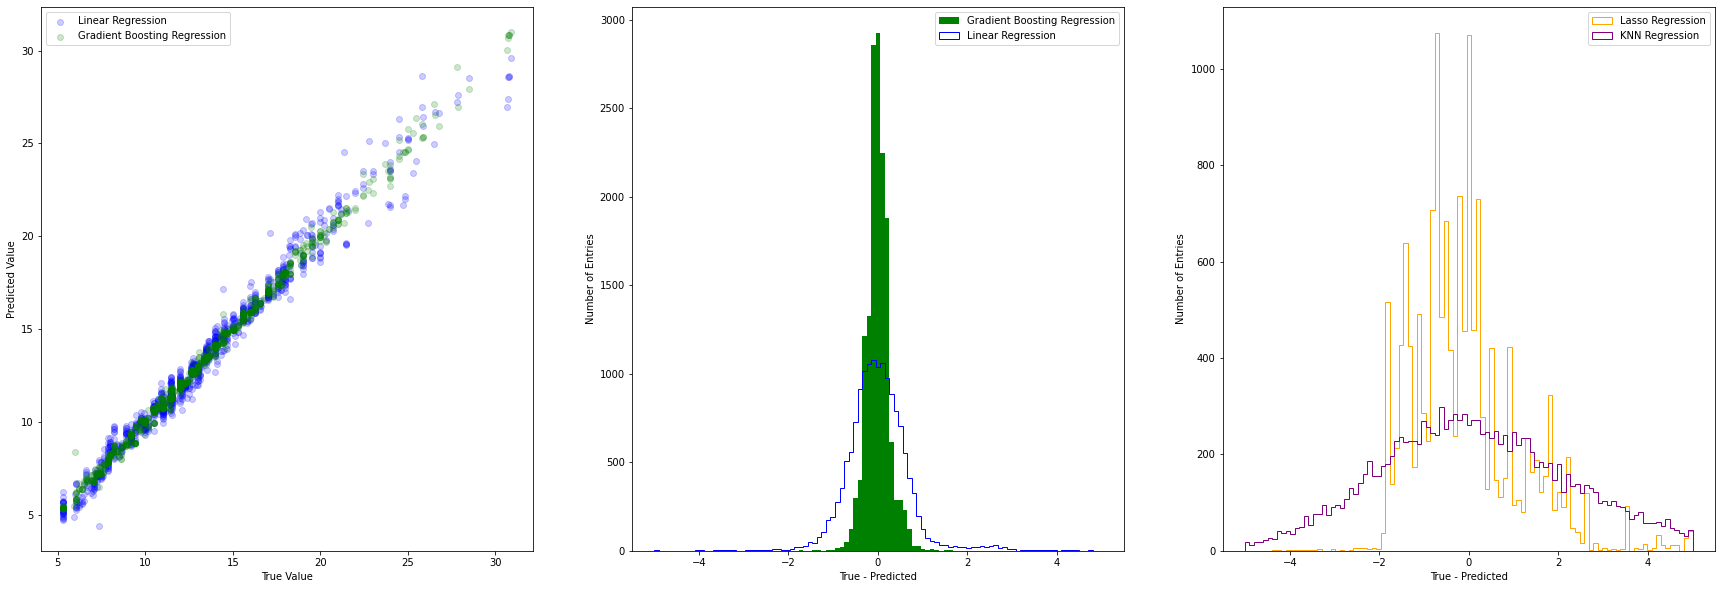

In [34]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (30,10))
ax1.scatter(y_test[:1000], clf_linear.predict(X_test)[:1000], color='blue', alpha=0.2,label='Linear Regression')
ax1.scatter(y_test[:1000], clf_gradboost.predict(X_test[:1000]), color='green', alpha=0.2, label='Gradient Boosting Regression')

ax2.hist( y_test.values.flatten() - clf_gradboost.predict(X_test).flatten(), np.linspace(-5,5,100), facecolor='green'  , label='Gradient Boosting Regression', histtype = 'stepfilled')
ax2.hist( y_test.values.flatten() - clf_linear.predict(X_test).flatten()   , np.linspace(-5,5,100), edgecolor='blue'   , label='Linear Regression', facecolor = "None", histtype = 'stepfilled')

ax3.hist( y_test.values.flatten() - clf_lasso.predict(X_test).flatten()    , np.linspace(-5,5,100), edgecolor='orange' , label='Lasso Regression', facecolor = "None", histtype = 'stepfilled')
ax3.hist( y_test.values.flatten() - knn_test_predictions.flatten()    , np.linspace(-5,5,100), edgecolor='purple' , label='KNN Regression', facecolor = "None", histtype = 'stepfilled')


ax1.set_xlabel('True Value')
ax1.set_ylabel('Predicted Value')
ax1.legend()
ax2.legend()
ax2.set_xlabel('True - Predicted')
ax2.set_ylabel('Number of Entries')
ax3.legend()
ax3.set_xlabel('True - Predicted')
ax3.set_ylabel('Number of Entries')
plt.show()

# Hyperparameter Tuning

The gradient boosting performs the best out of the models chosen on all counts. It has the best root mean squared error and this is consistent between the test and training samples, indicating there is none of the overfitting which is present in the other models. It's now worth spending some time trying to tune the hyperparameters of the algorithm to see if I can optimise a bit further. The number of hyperparameters possible is large, so I'll just pick a few, and vary one at a time.

In [22]:
default_gradboost_params = {
    'max_features' : None,
    'loss' : 'ls',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample' : 1.0,
    'criterion' : 'friedman_mse',
    'tol' : 1e-4}

param_grid = [
    {'regression__max_features' : [None, 'sqrt', 'log2']},
    {'regression__loss' : ['ls', 'lad']},
    {'regression__learning_rate': [0.1,1.0]},
    {'regression__n_estimators' : [100,200]}
]
search = GridSearchCV(clf_gradboost, param_grid, cv=2).fit(X, y)

# Final model training

Do a final train of the model using the parameters from the hyperparameter tuning

In [23]:
best_params = search.best_estimator_.named_steps['regression'].get_params()
print(best_params)
clf_gradboost.named_steps['regression'].set_params(**best_params)
clf_gradboost.fit(X_train, y_train)
print("model score: %.3f" % clf_gradboost.score(X_test, y_test))
print("root mean squared error (test)  : %.3f" % math.sqrt(mean_squared_error( y_test, clf_gradboost.predict(X_test))))
print("root mean squared error (train) : %.3f" % math.sqrt(mean_squared_error( y_train, clf_gradboost.predict(X_train))))

{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
model score: 0.996
root mean squared error (test)  : 0.285
root mean squared error (train) : 0.273


# Evaluation on separate test sample

The final step is to do the evaluation on the final test sample! We expect a mean-squared error given by the root mean squared error (test) above on the test sample. The scikitlearn pipeline allows us to load and process this sample in a straightforward manner.

In [31]:
dataframe_test = pd.read_csv('DataScienceAssignment/DataScienceAssignment_test.csv')
dataframe_test.drop_duplicates(inplace=True)
dataframe_test.set_index('id',inplace=True)

test_predictions = clf_gradboost.predict(dataframe_test)

final_test_preds = pd.DataFrame.from_dict({'id' : dataframe_test.index, 'int_rate' : test_predictions})
final_test_preds.to_csv('DataScienceAssignment/DataScienceAssignment_test_predictions.csv')

# Outlook

There are a number of things that could still be done with the regression model.
1. A more extensive exploration of the data. Can employee titles be grouped a bit better? Is the missing data really just missing data or does it indicate a certain value (i.e. inf. for the mths_since columns)? If the former, should it be penalised in the final evaluation?
2. Test even more models. It would be interesting to interface with xgboost and to try neural network regression which may capture some more of the complexity. A more extensive hyperparameter tuning could follow then.
3. Unit tests to ensure the processing and predictions behave as expected in training and when applied to any dataset. In particula validating the transforms are behaving as expected which can be a bit tricky in the column transformer framework.
4. Pickle final algorithm for deployment.